# Extracción de Landmarks con Mediapipe

## Instalación de líbrerias

In [22]:
pip install numpy opencv-python matplotlib requests

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Note: you may need to restart the kernel to use updated packages.


## Instalar la versión actualizada de mediapipe

In [2]:
pip install -U mediapipe

Note: you may need to restart the kernel to use updated packages.


## Extracción de Landmarks y Blendshapes del Rostro

### Descarga del Task para detectar los Landmarks en el Rostro

In [29]:
import requests

# URL del archivo que quieres descargar
url = 'https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/latest/face_landmarker.task'

# Realiza la solicitud para descargar el contenido
response = requests.get(url)

# Guardar el archivo en el directorio actual
file_name = url.split('/')[-1]  # Esto obtiene el nombre del archivo desde la URL
with open(file_name, 'wb') as file:
    file.write(response.content)

print(f"Archivo {file_name} descargado y guardado correctamente en el mismo directorio del proyecto.")


Archivo face_landmarker.task descargado y guardado correctamente en el mismo directorio del proyecto.


### Visualizar Blendshapes y Landmarks de una imagen y guardar solo los Blendshapes en un Csv

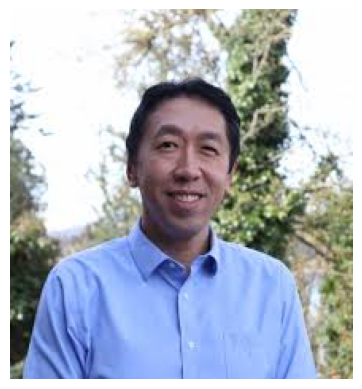

In [3]:
# Mostrar imagen
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen
image = cv2.imread('facial.jpg')

# Convertir la imagen de BGR a RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Mostrar la imagen
plt.imshow(image)
plt.axis('off')
plt.show()

c:\Users\ignac\anaconda3\envs\clase\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


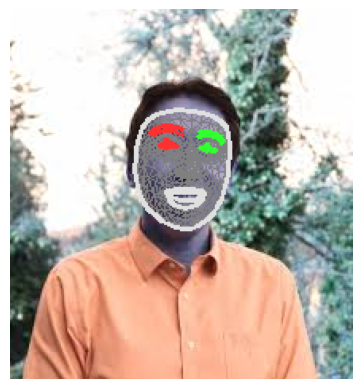

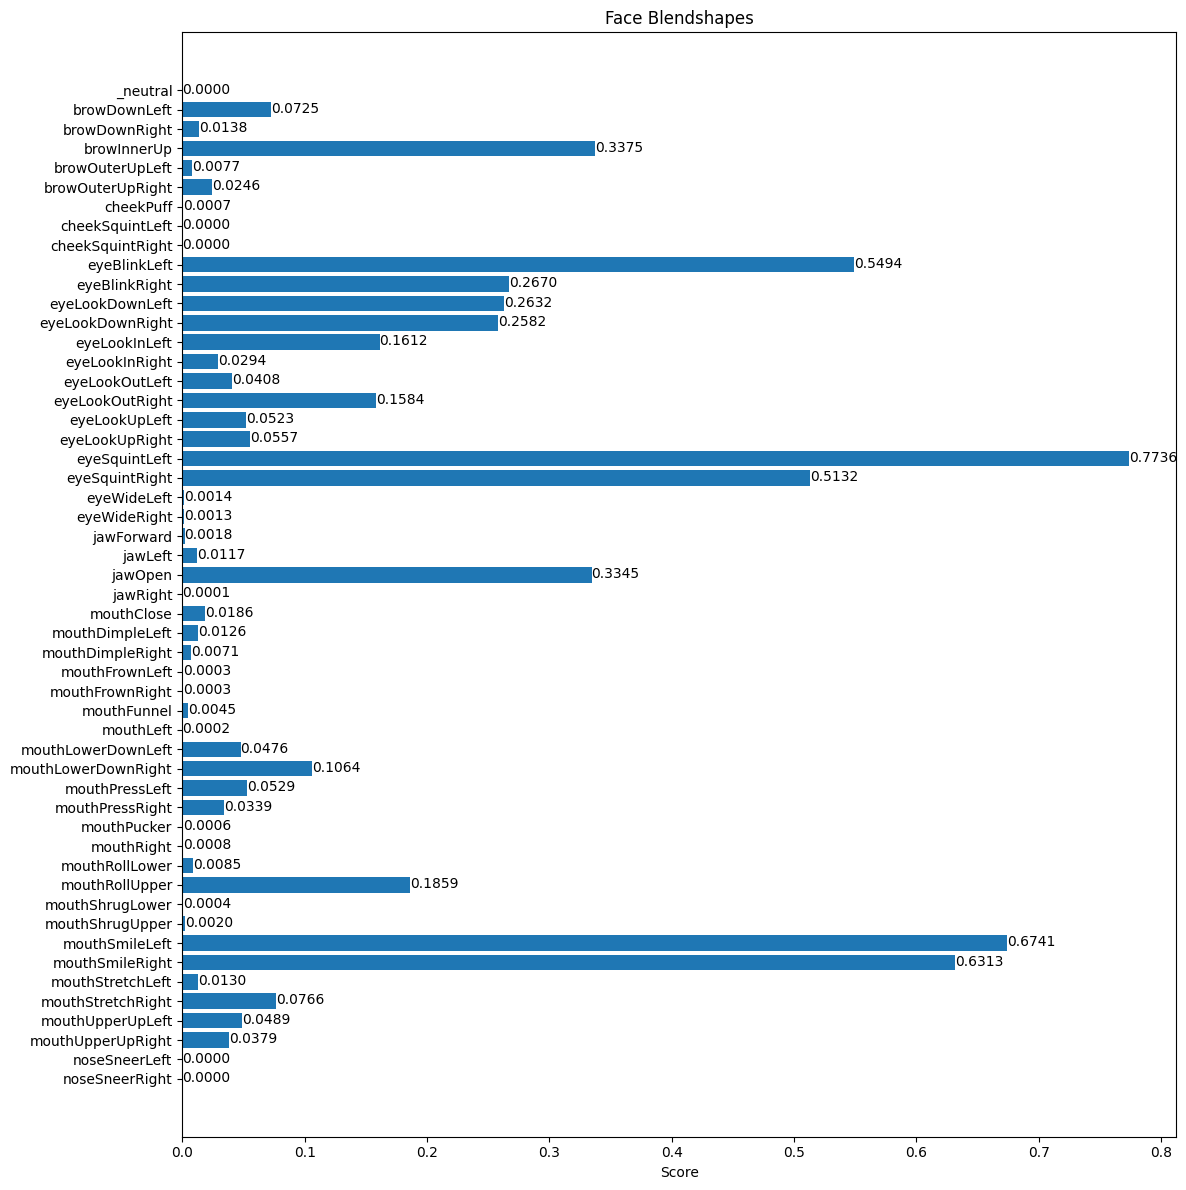

[array([[ 9.90910530e-01,  6.46657422e-02,  1.17961816e-01,
         4.33899939e-01],
       [-6.50174990e-02,  9.97883916e-01, -8.67817027e-04,
         4.25264454e+00],
       [-1.17768295e-01, -6.80967281e-03,  9.93018150e-01,
        -4.90421753e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]


In [1]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import csv

def draw_landmarks_on_image(rgb_image, detection_result):
    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(rgb_image)

    for idx in range(len(face_landmarks_list)):
        face_landmarks = face_landmarks_list[idx]
        face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        face_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_tesselation_style())
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_contours_style())
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_iris_connections_style())

    return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
    face_blendshapes_names = [category.category_name for category in face_blendshapes]
    face_blendshapes_scores = [category.score for category in face_blendshapes]
    face_blendshapes_ranks = range(len(face_blendshapes_names))

    fig, ax = plt.subplots(figsize=(12, 12))
    bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
    ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
    ax.invert_yaxis()

    for score, patch in zip(face_blendshapes_scores, bar.patches):
        plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

    ax.set_xlabel('Score')
    ax.set_title("Face Blendshapes")
    plt.tight_layout()
    plt.show()

def save_blendshapes_to_csv(face_blendshapes, filename='facial_blendshapes.csv'):
    headers = [blendshape.category_name for blendshape in face_blendshapes]
    scores = [blendshape.score for blendshape in face_blendshapes]
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Write category names as headers
        writer.writerow(scores)  # Write scores below the headers

# Create a FaceLandmarker object.
model_path = 'face_landmarker.task'
base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.FaceLandmarkerOptions(base_options=base_options, output_face_blendshapes=True, output_facial_transformation_matrixes=True, num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# Load the input image.
image_path = 'facial.jpg'
image = mp.Image.create_from_file(image_path)

# Detect face landmarks from the input image.
detection_result = detector.detect(image)

# Process the detection result and visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
plt.imshow(annotated_image_rgb)
plt.axis('off')
plt.show()

# Check if face blendshapes are detected and process them
if detection_result.face_blendshapes:
    plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])
    save_blendshapes_to_csv(detection_result.face_blendshapes[0])
    print(detection_result.facial_transformation_matrixes)
else:
    print("No face blendshapes detected.")


### Guardar Landmarks en otro Csv (incluyendo nombre de imagen y nombre de carpeta como etiquetas)

In [2]:
import cv2
import mediapipe as mp
import os
import csv

# Inicializar MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh

# Ruta a la imagen (ya no es una carpeta, sino una imagen específica)
image_path = 'facial.jpg'

# Función para procesar la imagen
def process_image(image_path, csv_writer):
    image = cv2.imread(image_path)
    image_name = os.path.basename(image_path)  # Obtener el nombre del archivo de la imagen
    folder_name = os.path.basename(os.path.dirname(image_path))  # Obtener el nombre de la carpeta de la imagen
    
    # Procesar la imagen con MediaPipe Face Mesh
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, 
                               min_detection_confidence=0.10) as face_mesh:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image_rgb)

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Extraer coordenadas de los landmarks
                landmarks = []
                for lm in face_landmarks.landmark:
                    landmarks.append([lm.x, lm.y, lm.z])
                
                # Guardar en CSV (incluyendo el nombre del archivo de la imagen)
                csv_writer.writerow([folder_name] + [image_name] + [coord for lm in landmarks for coord in lm])

# Obtener el directorio de trabajo actual
current_directory = os.getcwd()

# Crear archivo CSV en el directorio actual
csv_file_path = os.path.join(current_directory, 'facial_landmarks.csv')

with open(csv_file_path, 'w', newline='') as file:
    csv_writer = csv.writer(file)
    
    # Escribir los encabezados en el archivo CSV
    headers = ['folder'] + ['filename'] + ['x' + str(i) for i in range(1, 479)] + ['y' + str(i) for i in range(1, 479)] + ['z' + str(i) for i in range(1, 479)]
    csv_writer.writerow(headers)

    # Procesar la imagen
    process_image(image_path, csv_writer)

print(f"Archivo CSV guardado en: {csv_file_path}")


Archivo CSV guardado en: c:\Users\ignac\OneDrive\Desktop\New folder\facial_landmarks.csv


c:\Users\ignac\anaconda3\envs\clase\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


## Visualización de Landmarks de la Postura

### Descarga del Task para detectar los Landmarks en el Cuerpo

In [2]:
# Hay 3 modelos para pose_landmarker, usar el link que corresponda

# 1. pose_landmarker_lite.task
# 2. pose_landmarker_full.task
# 3. pose_landmarker_heavy.task

import requests

# URL del archivo que quieres descargar
url = 'https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/latest/pose_landmarker_heavy.task'

# Realiza la solicitud para descargar el contenido
response = requests.get(url)

# Guardar el archivo en el directorio actual
file_name = url.split('/')[-1]  # Esto obtiene el nombre del archivo desde la URL
with open(file_name, 'wb') as file:
    file.write(response.content)

print(f"Archivo {file_name} descargado y guardado correctamente en el mismo directorio del proyecto.")


Archivo pose_landmarker_heavy.task descargado y guardado correctamente en el mismo directorio del proyecto.


### Visualización

In [2]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image


In [4]:
import cv2

image = cv2.imread("pose.jpg")
cv2.imshow("test", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker_heavy.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("pose.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
# Add this line before imshow to make the window resizable
cv2.namedWindow("test", cv2.WINDOW_NORMAL)

# Existing code to display the image
cv2.imshow("test", annotated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()



In [7]:
segmentation_mask = detection_result.segmentation_masks[0].numpy_view()
visualized_mask = np.repeat(segmentation_mask[:, :, np.newaxis], 3, axis=2) * 255
cv2.imshow("test", visualized_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Visualización de Landmarks de la Mano en Tiempo Real

In [1]:
import cv2
import mediapipe as mp

# Initialize MediaPipe hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Set up webcam capture
webcam = cv2.VideoCapture(0)
with mp_hands.Hands(max_num_hands=3, min_detection_confidence=0.7, min_tracking_confidence=0.6) as hands:
    while webcam.isOpened():
        success, img = webcam.read()
        if not success:
            print("Ignoring empty camera frame.")
            continue

        # Convert the image color
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(img_rgb)

        # Draw landmarks
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(img_bgr, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # Show the image
        cv2.imshow('Hand Tracking', img_bgr)
        if cv2.waitKey(5) & 0xFF == ord("q"):
            break

# Release resources
webcam.release()
cv2.destroyAllWindows()


c:\Users\ignac\anaconda3\envs\clase\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
